#20240105 
Sarah Fong

- Harmonize atac seq data across replicates w same treatment condition
- Check spread of ATAC-seq scores. 
- Call differentially accessible peaks?
- No. Chengyu has DEseq data for this, but we're going to predict the accessibility peak value. 

In [1]:
LOCAL = False

In [9]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
#import pybedtools as pbt
from scipy import stats
import seaborn as sns

if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    DATA_PATH = "/Users/sarahfong/Desktop/local_data/US/ATAC"
    section = "data_local"
else:
    DATA_PATH ="/wynton/group/ahituv/data/US-MPRA/ATAC-seq/"
    section = "data_wynton"
import config_readwrite as crw

# open config

In [3]:
cfn_name = "config.atac.ini"
config, cfn = crw.read(cfn_name)

## params

In [53]:
PEAK_EXPANSION = 147
MIN_OVERLAP = PEAK_EXPANSION

## add data paths

In [54]:
crw.check(config, section)

# write
config[section]["path"] = DATA_PATH
config[section]["data"] = "%(path)s/*narrowPeak*"
config[section]["peak_expansion"] = str(PEAK_EXPANSION)

crw.write(config, cfn)

## input files

In [55]:
os.chdir(DATA_PATH)
peaks = glob.glob( "*.narrowPeak")
peaks

['BJ-C3-ATAC-q.7_peaks.narrowPeak',
 'BJ-T1-ATAC-q.7_peaks.narrowPeak',
 'BJ-T2-ATAC-q.7_peaks.narrowPeak',
 'BJ-T3-ATAC-q.7_peaks.narrowPeak',
 'HEPG2-C1-ATAC-q.7_peaks.narrowPeak',
 'HEPG2-C2-ATAC-q.7_peaks.narrowPeak',
 'HEPG2-C3-ATAC-q.7_peaks.narrowPeak',
 'HEPG2-T1-ATAC-q.7_peaks.narrowPeak',
 'HEPG2-T2-ATAC-q.7_peaks.narrowPeak',
 'HEPG2-T3-ATAC-q.7_peaks.narrowPeak',
 'HOB-C1-ATAC-q.7_peaks.narrowPeak',
 'HOB-C2-ATAC-q.7_peaks.narrowPeak',
 'HOB-C3-ATAC-q.7_peaks.narrowPeak',
 'HOB-T1-ATAC-q.7_peaks.narrowPeak',
 'HOB-T2-ATAC-q.7_peaks.narrowPeak',
 'HOB-T3-ATAC-q.7_peaks.narrowPeak',
 'K562-C1-ATAC-q.7_peaks.narrowPeak',
 'K562-C2-ATAC-q.7_peaks.narrowPeak',
 'K562-C3-ATAC-q.7_peaks.narrowPeak',
 'K562-T1-ATAC-q.7_peaks.narrowPeak',
 'K562-T2-ATAC-q.7_peaks.narrowPeak',
 'K562-T3-ATAC-q.7_peaks.narrowPeak',
 'BJ-C1-ATAC-q.7_peaks.narrowPeak',
 'BJ-C2-ATAC-q.7_peaks.narrowPeak']

In [56]:
data = {}
for file in peaks:
    # str split file
    cl, rep = file.split("-")[:2]

    names = ["#chr", "start", "end", "name",
             'score', "strand", "signal_val", "p", "q", "peak"]  # name columns

    df = pd.read_csv(file, sep='\t', header=None, names=names)  # open data
    print(cl, rep)  # , df.shape)  # report info

    df["cl"], df["rep"] = cl, rep  # name columns with info
    df["exp"] = df["rep"].apply(lambda x: list(x)[0])  # add exposure column,

    ###
    # centering - 135 bases from peaks
    ###

    centered = df.copy()

    centered["peakcenter_start"] = centered["start"] + centered["peak"] - \
        PEAK_EXPANSION  # new start subtract from peak center
    
    centered["peakcenter_end"] = centered["peakcenter_start"] + (PEAK_EXPANSION*2)  # new end double the peak expansion
    
    centered.loc[centered['peakcenter_start']<0, "peakcenter_start"] = centered['start']

    # quantile normalize scores for each replicate.
    centered['score_q'] = centered["score"].rank(pct=True)

    # print some descricenteredptive stats
    print(centered[["score", "score_q"]].describe())

    # add to dictionary
    data[f'{cl+rep}'] = centered

    # save centered file
    out = f'{cl}.{rep}.centered.peaks'

    new_names = ['#chr',
                 "peakcenter_start",
                 "peakcenter_end",
                 'name',
                 'score',
                 'strand',
                 'signal_val',
                 'p',
                 'q',
                 'peak',
                 'cl',
                 'rep',
                 'exp', 
                 'start',
                 'end']
    # if os.path.exists(out) is False:
    centered[new_names].to_csv(out, sep='\t', index=False)


BJ C3
              score       score_q
count  65066.000000  65066.000000
mean     102.383103      0.500008
std      299.491541      0.288249
min        1.000000      0.000784
25%       21.000000      0.248832
50%       47.000000      0.502843
75%      106.000000      0.749439
max    30421.000000      1.000000
BJ T1
               score        score_q
count  129908.000000  129908.000000
mean      191.721895       0.500004
std       399.286955       0.288394
min         1.000000       0.000866
25%        25.000000       0.268478
50%        63.000000       0.485324
75%       198.000000       0.750458
max     33397.000000       1.000000
BJ T2
             score       score_q
count  82377.00000  82377.000000
mean     117.57056      0.500006
std      311.51882      0.288216
min        1.00000      0.000753
25%       22.00000      0.283325
50%       50.00000      0.509675
75%      120.00000      0.749402
max    32658.00000      1.000000
BJ T3
               score        score_q
count  102249

### concat data

In [57]:
df = pd.concat(data.values())

print(df.shape)

df.head()

(3358581, 16)


#chr  start    end                   name  score strand  signal_val  \
0  chr1  10003  10604  BJ-C3-ATAC-q.7_peak_1    509      .    21.67300   
1  chr1  11189  11428  BJ-C3-ATAC-q.7_peak_2     28      .     4.17585   
2  chr1  29113  29765  BJ-C3-ATAC-q.7_peak_3    161      .     9.78418   
3  chr1  32558  32904  BJ-C3-ATAC-q.7_peak_4    109      .     6.91283   
4  chr1  34426  34989  BJ-C3-ATAC-q.7_peak_5    142      .     8.62780   

          p         q  peak  cl rep exp  peakcenter_start  peakcenter_end  \
0  55.09760  50.99550    82  BJ  C3   C              9938           10232   
1   5.44473   2.87332   131  BJ  C3   C             11173           11467   
2  19.44800  16.15090   221  BJ  C3   C             29187           29481   
3  14.05880  10.96360   119  BJ  C3   C             32530           32824   
4  17.50700  14.27810   403  BJ  C3   C             34682           34976   

    score_q  
0  0.970768  
1  0.358882  
2  0.840685  
3  0.755863  
4  0.815679

## filter peaks criteria

other ideas:
- reproducible discovery rate
- Frip - fraction of reads in peak score. 
- REMOVE blacklist!!! (mitochondrial reads)

other followup
- Get deseq2 calls - for classification model?
- quantile normalization of scores. 

## check raw score distribution, filtered for q-value, score<100

/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

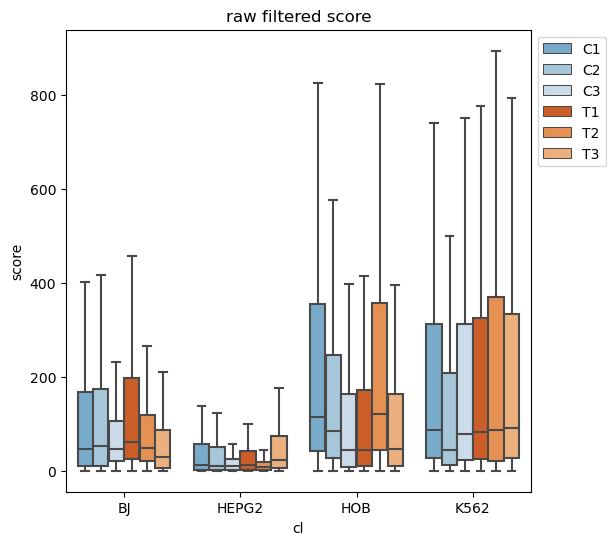

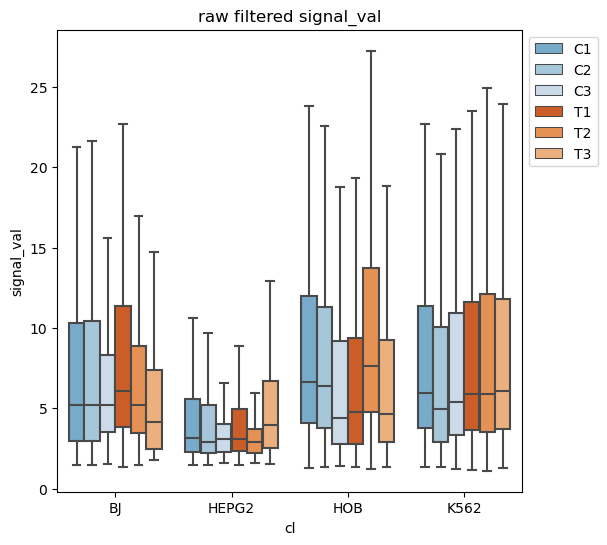

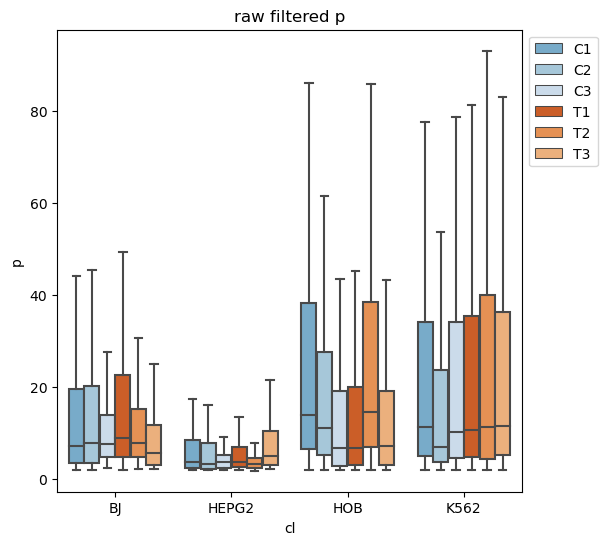

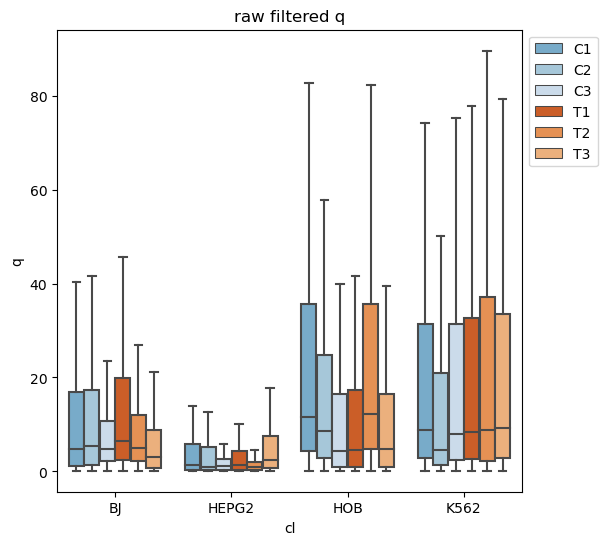

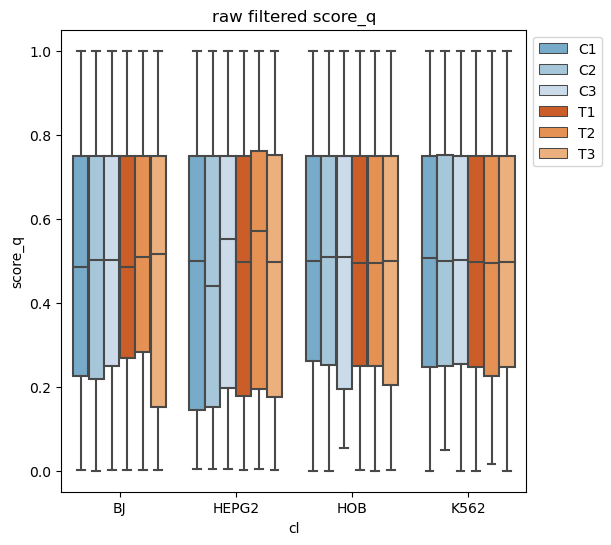

In [27]:
vals = ["score", "signal_val", "p", "q", "score_q"]
x="cl"

data=df#.loc[df["cl"]=="BJ"]#.sample(frac=0.1)
hue ="rep"
hue_order = ['C1', 'C2', 'C3', 'T1', 'T2', 'T3']
palette='tab20c'

for y in vals:
    y=y
    title= f"raw filtered {y}"

    fig, ax=plt.subplots(figsize=(6,6))
    sns.boxplot(x=x, y=y, data=data, 
                hue=hue, hue_order=hue_order, 
                palette=plt.cm.tab20c.colors[1:], 
                showfliers=False)
    ax.set(title=title)
    ax.legend(bbox_to_anchor=(1,1))

## count peaks per cell-type, rep

In [72]:
counts = df.groupby(["cl","exp", "rep"])["score"].count().reset_index()

counts =counts.rename(columns={"score":"counts"})
counts["counts"].describe()  # summarize stats for all count data 

count        24.000000
mean     139940.875000
std       45415.927236
min       65066.000000
25%      104792.250000
50%      131109.500000
75%      173251.250000
max      241002.000000
Name: counts, dtype: float64

In [73]:
# summary of counts across replicates
counts.groupby(["cl", "exp"])["counts"].describe()

count           mean           std       min       25%       50%  \
cl    exp                                                                     
BJ    C      3.0  118003.000000  46028.337131   65066.0  102715.5  140365.0   
      T      3.0  104844.666667  23871.575238   82377.0   92313.0  102249.0   
HEPG2 C      3.0  209395.000000  29890.732828  181583.0  193591.5  205600.0   
      T      3.0  160709.000000  62236.758568   96502.0  130679.5  164857.0   
HOB   C      3.0  149526.000000  33187.079097  116879.0  132675.0  148471.0   
      T      3.0  160648.000000  24739.426166  132311.0  151998.5  171686.0   
K562  C      3.0  110050.000000  16459.927065   91160.0  104418.5  117677.0   
      T      3.0  106351.333333   3796.639874  103167.0  104250.5  105334.0   

                75%       max  
cl    exp                      
BJ    C    144471.5  148578.0  
      T    116078.5  129908.0  
HEPG2 C    223301.0  241002.0  
      T    192812.5  220768.0  
HOB   C    165849.5  183228.0  
      T    174816.5  177947.0  
K562  C    119495.0  121313.0  
      T    107943.5  110553.0

In [76]:
x="cl"
y="counts"
data=counts
hue="rep"
title = "peak counts, filtered on q<0.001 and score >100"

[Text(0.5, 1.0, 'peak counts, filtered on q<0.001 and score >100')]

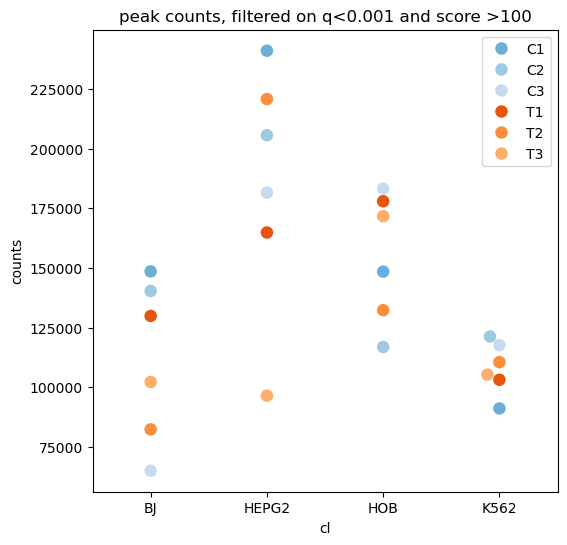

In [77]:
fig, ax = plt.subplots(figsize=(6,6))
sns.swarmplot(x=x,y=y,data=data, 
              hue=hue, hue_order=hue_order, 
              palette=plt.cm.tab20c.colors[1:],
             size=9)
ax.legend(bbox_to_anchor=(1,1))
ax.set(title=title)

# multi intersect

In [28]:
centered_ = glob.glob("*centered.peaks") # get all the files

reps = {}
for f in centered_:

    # get cl and replicate
    cl, rep = f.split(".")[:2]

    # get exposure - treated or control
    exposure=list(rep)[0]

    # add cl+exposure and file to dictionary
    key=f"{cl}.{exposure}"

    
    if key not in reps:
        print("new key", key, f)
        reps[key] = [f]
    else:
        rep_list = reps[key]
        rep_list.append(f)
        reps[key] = rep_list
    

new key BJ.C BJ.C3.centered.peaks
new key BJ.T BJ.T2.centered.peaks
new key HEPG2.C HEPG2.C1.centered.peaks
new key HEPG2.T HEPG2.T1.centered.peaks
new key HOB.C HOB.C2.centered.peaks
new key HOB.T HOB.T2.centered.peaks
new key K562.C K562.C1.centered.peaks
new key K562.T K562.T1.centered.peaks


## bedtoosl multiintersect command and filtering for peaks in all three datasets. 

In [58]:
consensus_files = {}
for key, val in reps.items():
    out = key + ".centered.multi.bed"  # file to write to
    
    for i in val:
        os.system(f"bedtools sort -i {i} > t && mv t {i}")
    
    # build bedtools multi command
    cmd =["bedtools multiinter -i"]
    cmd.extend(val)
    cmd.append(f" > {out}")
    cmd = " ".join(cmd)

    # perform multi-intersect, if not already done.
    #if os.path.exists(out) is False:
    os.system(cmd)

    # get peaks found in all 3 datasets
    consen_out = key + ".centered.multi.3.bed"
    test = pd.read_csv(out, sep='\t', header=None)

    # fitler
    consen = test.loc[test[3]==3].copy() # keep only 3 overlaps
    
    # colunm formatting
    consen.columns=["#chr", "start", "end", "count", "reps", "rep1", 'rep2', "rep3"]
    consen["len"] = consen["end"] - consen["start"] # compute lengths of overlapping peaks
    consen["cl.exp"]= key  # add key identity
    
    print('before filtering overlaps', consen.shape)
    # filter peaks with 200+ bp overlap
    consen = consen.loc[consen["len"]>PEAK_EXPANSION]
    
    print('after filtering overlaps', consen.shape)
    
    # filter - peak overlaps all three datasets
    print(key, consen["len"].describe())  # summary stat of length
    
    # write
    consen[["#chr", "start", "end", "count", "len","cl.exp"]].to_csv(consen_out, sep='\t', index=False)

    consensus_files[consen_out] = consen[["#chr", "start", "end", "count", "len","cl.exp"]]

before filtering overlaps (47220, 10)
after filtering overlaps (43061, 10)
BJ.C count    43061.000000
mean       244.778454
std         35.427614
min        148.000000
25%        222.000000
50%        250.000000
75%        273.000000
max        572.000000
Name: len, dtype: float64
before filtering overlaps (48855, 10)
after filtering overlaps (44428, 10)
BJ.T count    44428.000000
mean       242.783222
std         35.602510
min        148.000000
25%        219.000000
50%        248.000000
75%        271.000000
max        572.000000
Name: len, dtype: float64
before filtering overlaps (57476, 10)
after filtering overlaps (50194, 10)
HEPG2.C count    50194.000000
mean       242.468980
std         35.826575
min        148.000000
25%        219.000000
50%        248.000000
75%        271.000000
max        573.000000
Name: len, dtype: float64
before filtering overlaps (40607, 10)
after filtering overlaps (35396, 10)
HEPG2.T count    35396.000000
mean       238.709176
std         36.478612
mi

In [59]:
con = pd.concat(consensus_files.values())
print(con.shape)
con.head()

(462972, 6)


#chr  start    end  count  len cl.exp
2   chr1   9941  10229      3  288   BJ.C
7   chr1  11173  11457      3  284   BJ.C
17  chr1  29190  29467      3  277   BJ.C
25  chr1  34682  34950      3  268   BJ.C
34  chr1  96535  96811      3  276   BJ.C

## consensus peak lengths per replicate

/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: xlabel='len', ylabel='Density'>

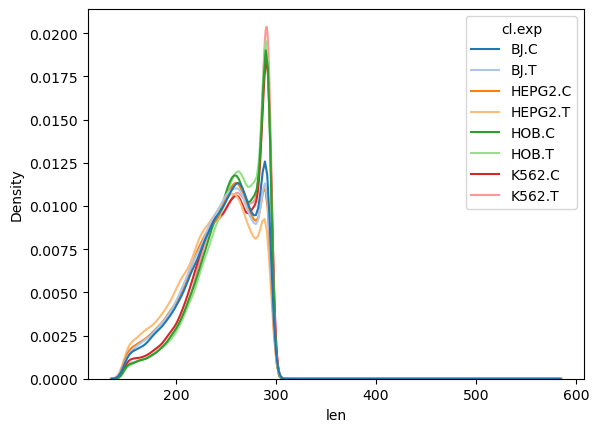

In [60]:
# consensus peak lengths per replicate
sns.kdeplot(x="len", data=con.sort_values(by="cl.exp"), hue="cl.exp", common_norm=False, palette="tab20")

# back-intersect into each replicate

In [85]:
# get mean scores for consensus peaks by back-intersecting w original data.
peak_outs = {}
for key in consensus_files.keys():
    group = ".".join(key.split(".")[:2])
    for peak_file in centered_:
        if group in peak_file:
            
            out = key.strip(".bed") + "." + peak_file + ".bed"
            cmd = " ".join([
                "bedtools intersect -a",
                key,  # consensus peak set
                "-b",
                peak_file,  # replicate peak set
                "-f 0.5",  # 50% of consensus peak must overlap in -b
                "-wa -wb >", 
                out # write to file
            ])
            
            if os.path.exists(out) is False:  # do intersection only once
                os.system(cmd)
                
            # add file to dictionary
            if group not in peak_outs.keys():
                peak_outs[group] = [out]
            else:
                peak_outlist = peak_outs[group]
                peak_outlist.append(out)
                peak_outs[group] = peak_outlist


## get scores for each peak in each replicate. 

In [183]:
names = ["#chr", "start_peakcons", "end_peakcons", "n_repcons", "lencons",
         "group", "#chr_rep", 'start_center_rep', "end_center_rep", "sample_id",
         "score", 'strand', "signal_val", "p", "q", "peak_center",
         "cl", "rep", "treatment",
         "start_rep", 'end_rep'
         ]  # column file names

usecols = ["#chr", "start_peakcons", "end_peakcons", "lencons",
           "group", 
           "score", 
           "cl", "rep", 
           ]  # column file names


results={}
for key, peak_files in peak_outs.items():  # per group
    peaks = {}
    for peak_file in peak_files:  # per file, load data
        peaks[peak_file] = pd.read_csv(peak_file, sep='\t',
                           header=None,
                           names=names, usecols=usecols
                           )
    # clean up peak/condition set
    test = pd.concat(peaks.values()).drop_duplicates().reset_index(drop=True)

    # make coordinate str
    test["coor"] = test["#chr"] + ":" + \
        test["start_peakcons"].map(str) + '-' + test["end_peakcons"].map(str)

    # remove funny datapoint(s) that have more/less than 3 rep measurements
    count_reps = test.groupby("coor")["#chr"].count().reset_index()
    
    # get ids that don't have 3 read measurements. 
    remove_coor = count_reps.loc[count_reps["#chr"] != 3, "coor"]
    test = test.loc[~test["coor"].isin(remove_coor)]

    # add to dictionary
    results[key] = test

In [203]:
len(set(results['HEPG2.C']["coor"]).difference(set(results['HEPG2.T']["coor"])))

49828

In [205]:
results['HEPG2.C']

#chr  start_peakcons  end_peakcons  lencons    group  score     cl  \
0       chr1            9941         10234      293  HEPG2.C   2936  HEPG2   
1       chr1           11167         11461      294  HEPG2.C    217  HEPG2   
2       chr1           19853         20106      253  HEPG2.C    187  HEPG2   
3       chr1           29194         29460      266  HEPG2.C    371  HEPG2   
4       chr1           96587         96845      258  HEPG2.C     69  HEPG2   
...      ...             ...           ...      ...      ...    ...    ...   
150597  chrY        56765207      56765400      193  HEPG2.C     71  HEPG2   
150598  chrY        56767232      56767514      282  HEPG2.C     58  HEPG2   
150599  chrY        56768510      56768755      245  HEPG2.C    194  HEPG2   
150600  chrY        56839281      56839551      270  HEPG2.C     75  HEPG2   
150601  chrY        56850694      56850961      267  HEPG2.C    148  HEPG2   

       rep                    coor  
0       C1         chr1:9941-10234  
1       C1        chr1:11167-11461  
2       C1        chr1:19853-20106  
3       C1        chr1:29194-29460  
4       C1        chr1:96587-96845  
...     ..                     ...  
150597  C2  chrY:56765207-56765400  
150598  C2  chrY:56767232-56767514  
150599  C2  chrY:56768510-56768755  
150600  C2  chrY:56839281-56839551  
150601  C2  chrY:56850694-56850961  

[150528 rows x 9 columns]

## evaluate 1 cell type, 1 set of replicates

In [206]:
test = results['HEPG2.C']
table = pd.pivot(test.fillna(0), index="coor", columns="rep", values="score")
table.head()

rep                         C1   C2   C3
coor                                    
chr10:100006476-100006646  279  168   85
chr10:100046103-100046327   77   64   52
chr10:100085664-100085939  261  332  170
chr10:100101602-100101853  472  764  263
chr10:100111770-100112005   73   20   11

In [207]:
table.describe()

rep              C1            C2            C3
count  50176.000000  50176.000000  50176.000000
mean     269.235850    250.434790    136.961476
std      466.750725    484.915344    408.676956
min        1.000000      1.000000      1.000000
25%       69.000000     56.000000     26.000000
50%      150.000000    126.000000     60.000000
75%      328.000000    289.000000    145.000000
max    40235.000000  37849.000000  37457.000000

In [171]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [208]:
ss = RobustScaler() #StandardScaler()
scaled = ss.fit_transform(table)
scaled = pd.DataFrame(scaled)
scaled.columns = list(table)

/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

In [209]:
scaled.corr()

C1        C2        C3
C1  1.000000  0.970168  0.932060
C2  0.970168  1.000000  0.956698
C3  0.932060  0.956698  1.000000

In [210]:
scaled.describe()

C1            C2            C3
count  50176.000000  50176.000000  50176.000000
mean       0.460370      0.534055      0.646735
std        1.802126      2.081182      3.434260
min       -0.575290     -0.536481     -0.495798
25%       -0.312741     -0.300429     -0.285714
50%        0.000000      0.000000      0.000000
75%        0.687259      0.699571      0.714286
max      154.768340    161.901288    314.260504

In [211]:
scaled["mean"] = scaled.mean(axis=1)

scaled["mean"].describe()

## standard scaler

In [214]:
ss = StandardScaler()
stscaled = ss.fit_transform(table)
stscaled = pd.DataFrame(stscaled)
stscaled.columns = list(table)

/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

In [215]:
stscaled.describe()

C1            C2            C3
count  5.017600e+04  5.017600e+04  5.017600e+04
mean  -5.041319e-17 -3.398642e-18 -3.823472e-18
std    1.000010e+00  1.000010e+00  1.000010e+00
min   -5.746933e-01 -5.143934e-01 -3.326902e-01
25%   -4.290038e-01 -4.009705e-01 -2.715166e-01
50%   -2.554619e-01 -2.566139e-01 -1.883205e-01
75%    1.259018e-01  7.953057e-02  1.966983e-02
max    8.562635e+01  7.753712e+01  9.132008e+01

In [216]:
stscaled.corr()

C1        C2        C3
C1  1.000000  0.970168  0.932060
C2  0.970168  1.000000  0.956698
C3  0.932060  0.956698  1.000000

In [217]:
stscaled["mean"] = stscaled.mean(axis=1)

stscaled["mean"].describe()

count    5.017600e+04
mean    -1.642677e-17
std      9.842102e-01
min     -4.718099e-01
25%     -3.579901e-01
50%     -2.325759e-01
75%      6.983548e-02
max      8.290945e+01
Name: mean, dtype: float64